[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagar87/scPCA/blob/main/docs/notebooks/kang.ipynb)

<div class="admonition note"> 
    <p class="admonition-title">Note</p>
    <p>In order to run this notebook in Google Colab run the following cells. For best performance make sure that you run the notebook on a GPU instance, i.e. choose from the menu bar Runtime > Change Runtime > Hardware accelerator > GPU.</p> 
</div>

In [3]:
# Install scPCA + dependencies
!pip install --quiet scpca scikit-misc

In [2]:
# Download the Kang et. al. dataset
!wget https://www.huber.embl.de/users/harald/sc/kang.h5ad /content/kang.h5ad

# Analysing the lung cell populations in aging mice

In this notebook, we analyse the dataset from Hrvatin et. al. in which the authors investigated light stimulated brain cells after various time points.

In [1]:
import scpca as scp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

## Data preprocessing

We begin by importing the dataset with `scanpy`.

In [2]:
data_path = '/home/voehring/voehring/projects/2022-11-23_constantin/hrvatin.h5ad'
adata = sc.read_h5ad(data_path)

In [3]:
adata

AnnData object with n_obs × n_vars = 65539 × 25187
    obs: 'Cell', 'stim', 'sample', 'maintype', 'celltype', 'subtype'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay'

Examining the obs field of the `adata` object reveals that the dataset includes three different time points (0h, 1h and 4h) in the `stim` column.

In [4]:
adata.obs

,Cell,stim,sample,maintype,celltype,subtype
x2_35_0_bc0013,x2_35_0_bc0013,0h,B1_1_0h,Excitatory,ExcL4,ExcL4_3
x2_35_0_bc0014,x2_35_0_bc0014,0h,B1_1_0h,Excitatory,ExcL5_3,NA
x2_35_0_bc0016,x2_35_0_bc0016,0h,B1_1_0h,Excitatory,ExcL5_2,NA
x2_35_0_bc0017,x2_35_0_bc0017,0h,B1_1_0h,Excitatory,ExcL6,NA
x2_35_0_bc0018,x2_35_0_bc0018,0h,B1_1_0h,Excitatory,ExcL5_3,NA
...,...,...,...,...,...,...
x2_98_4_2_2_bc2789,x2_98_4_2_2_bc2789,4h,B7_23_4h_B,NA,NA,NA
x2_98_4_2_2_bc2805,x2_98_4_2_2_bc2805,4h,B7_23_4h_B,Microglia,Micro_2,NA
x2_98_4_2_2_bc2823,x2_98_4_2_2_bc2823,4h,B7_23_4h_B,NA,NA,NA
x2_98_4_2_2_bc2857,x2_98_4_2_2_bc2857,4h,B7_23_4h_B,NA,NA,NA


Before proceeding with the selection of highly variable genes, we filter out low-quality ("NA") cells.

In [5]:
adata = adata[~adata.obs['maintype'].isin(['NA'])]

In [6]:
adata.layers["counts"] = adata.X.copy()

/tmp/ipykernel_3037/1517723426.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

## Factor analysis

Next, we model the data using scPCA. One strategy is to designate the 0h condition as the reference and capture gene expression shifts after 1h and 4h as deviations from this baseline. This can be specified using the design formula `~ stim`, similar to how one would define a model in a linear regression framework.

In [8]:
m0 = scp.scPCA(
    adata, 
    num_factors=10,
    layers_key='counts',
    loadings_formula='stim',
    intercept_formula='1',
    seed=3258035
)

In [9]:
m0.fit()

  0%|          | 0/5000 [00:00<?, ?it/s]/g/huber/users/voehring/conda/scpca_dev/lib/python3.12/site-packages/scpca/models/scpca.py:68: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  α_rna = deterministic("α_rna", (1 / α_rna_inv).T)
Epoch: 4990 | lr: 1.00E-02 | ELBO: 24579048 | Δ_10: -454472.00 | Best: 23914962: 100%|██████████| 5000/5000 [02:21<00:00, 35.28it/s] 


In [10]:
m0.fit(lr=0.001, num_epochs=10000)

Epoch: 14990 | lr: 1.00E-03 | ELBO: 23639794 | Δ_10: -142348.00 | Best: 23275284: 100%|██████████| 10000/10000 [04:38<00:00, 35.87it/s]


Let's store the result in the `adata` object.

In [11]:
m0.mean_to_anndata(model_key='m0', num_samples=10, num_split=512)

Predicting z for obs 48128-48265.: 100%|██████████| 95/95 [00:05<00:00, 16.93it/s]


If we now take a close look at the adata object we will find that the factors and loadings were added to the `obsm` and `varm` fields respectively (`X_m0` and `W_m0`). Meta data related to the factorisation are stored under `adata.uns[{model_key}]`.

In [12]:
adata

AnnData object with n_obs × n_vars = 48266 × 2000
    obs: 'Cell', 'stim', 'sample', 'maintype', 'celltype', 'subtype'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'celltype_column', 'condition_column', 'main_assay', 'hvg', 'm0'
    obsm: 'X_m0'
    varm: 'W_m0'
    layers: 'counts'

Let's check our factor representation by getting a visual overview using UMAP. We use the UMAP helper function of scpca to accomplish that.

In [14]:
scp.tl.umap(adata, 'X_m0')

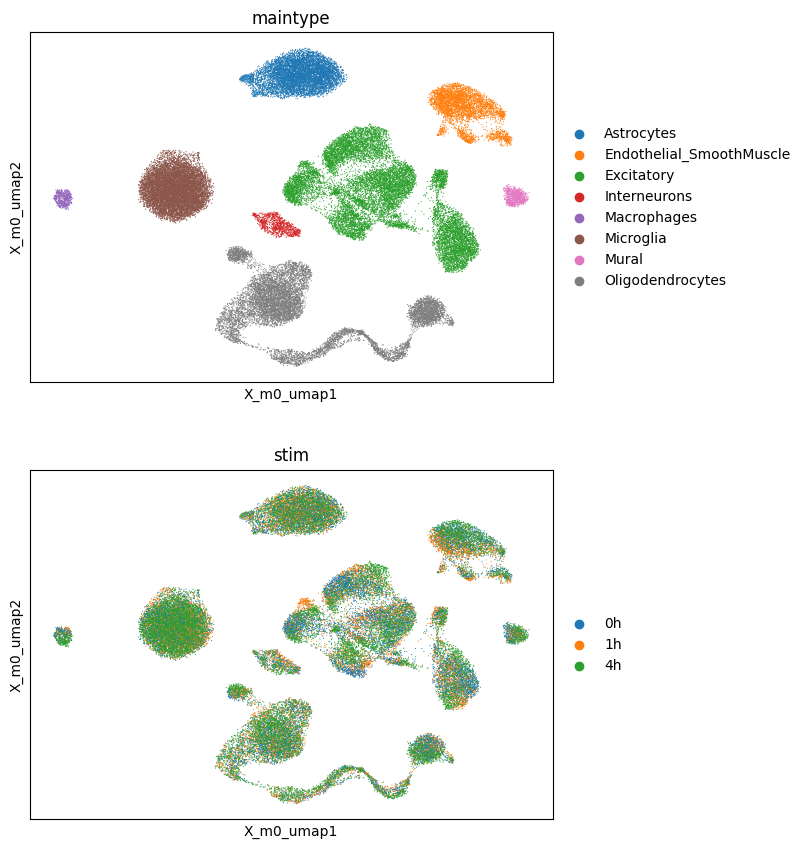

In [15]:
sc.pl.embedding(adata, basis='X_m0_umap', color=['maintype', 'stim'], ncols=1)

We now try to assess the main factors of the decomposition.

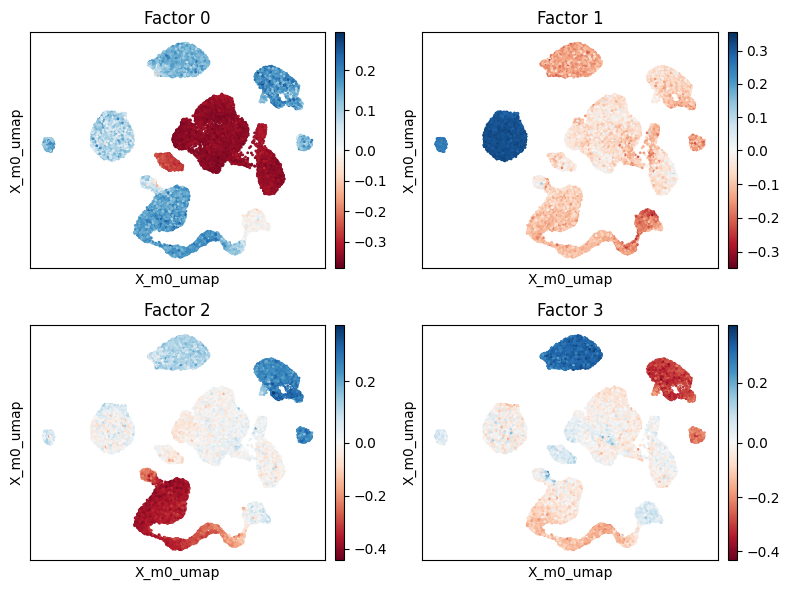

In [16]:
scp.pl.factor_embedding(adata, model_key='m0', factor=[0, 1, 2, 3], basis='X_m0_umap', ncols=2)
plt.tight_layout()

### Factor 0

We begin by examining factor 0 more closely. This factor seems to delineate variation between Excitatory/Interneurons and all other cell types.

<Axes: title={'center': 'Factor 0'}, xlabel='cluster', ylabel='Factor weight'>

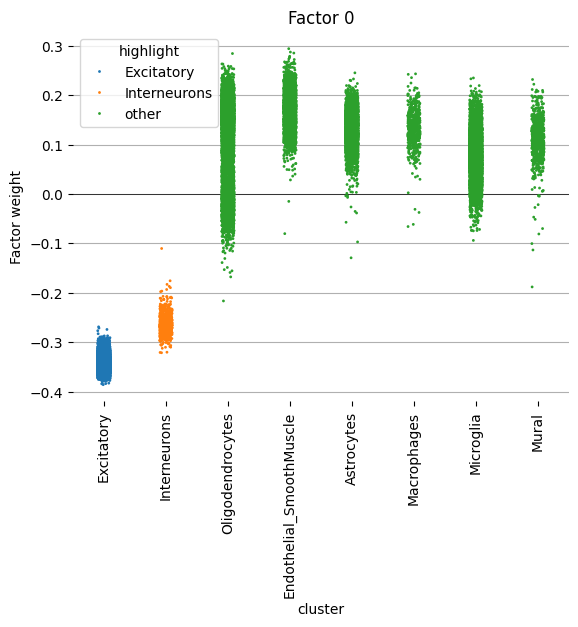

In [17]:
scp.pl.factor_strip(adata, model_key='m0', factor=[0], cluster_key='maintype', highlight=['Excitatory', 'Interneurons'], s=2)

Next we take a close look at the _negative_ loading weights of factor 0 to learn more about the expression patterns in the myeloid cells of this dataset. We can extract those from the `adata` object using the `state_loadings` function. We use the argument `lowest=20` and `highest=0` to extract the genes with the largest negative weights.

In [19]:
top_weights_fac0 = scp.tl.state_loadings(adata, 'm0', 'Intercept', 0, highest=0, lowest=20)

In [23]:
top_weights_fac0

,gene,magnitude,weight,type,state,factor,index
0,Mal2,10.400877,-10.400877,lowest,0,0,1150
1,Slc6a7,10.412316,-10.412316,lowest,0,0,1699
2,Slc12a5,10.412939,-10.412939,lowest,0,0,1649
3,Trank1,10.452961,-10.452961,lowest,0,0,1889
4,Gabrg2,10.481948,-10.481948,lowest,0,0,729
5,Slc17a7,10.504766,-10.504766,lowest,0,0,1657
6,Tbr1,10.507494,-10.507494,lowest,0,0,1807
7,Adcy1,10.556755,-10.556755,lowest,0,0,116
8,Phf24,10.618876,-10.618876,lowest,0,0,1409
9,Rbfox3,10.658419,-10.658419,lowest,0,0,1531


Expectedly, ee find that these these loadings indicate excitatory neurons.

| Gene | Annotation |
|------|------------|
| **Slc17a7 (VGLUT1)** | Marker of **glutamatergic (excitatory) neurons**, especially in cortex and hippocampus. |
| **Tbr1** | Transcription factor enriched in **layer 6 excitatory neurons** of the cortex. |
| **Rbfox3 (NeuN)** | General **neuronal marker**, nuclear protein expressed in most mature neurons. |
| **Gabra1**, **Gabrg2** | Encode GABA-A receptor subunits – expressed in both inhibitory and excitatory neurons (receptive to GABA). |
| **Cck**, **Lamp5** | Typically associated with **interneurons**, but also found in specific **excitatory subtypes**, particularly in superficial cortical layers. |
| **Slc12a5 (KCC2)** | Potassium-chloride transporter critical for **neuronal chloride homeostasis** – enriched in mature **excitatory neurons**. |
| **Slc6a7** | High-affinity **L-proline transporter**, enriched in **glutamatergic neurons**, possibly in **layer 5/6**. |
| **Mal2**, **Kalrn**, **Adcy1**, **Phf24**, **Trank1**, **Gpr88**, **Sncb**, **Myt1l**, **Vsnl1**, **Nptx1**, **Sv2b** | Involved in **synaptic function**, **neuronal maturation**, and **plasticity**. Most are enriched in **excitatory neurons** of the cortex. |


Next, we would like to understand how the factor 0 weights change across the condtitions. We provide the `scp.pl.loadings_scatter` function to visualise the loading weights across several condtions. This function requires us to specify the genes we want to visualise. To find interesting genes we focus on the genes with largest loading state differences between the 0h and 1h condition.

In [33]:
loading_diff0 = scp.tl.state_diff(adata, model_key='m0', states=['Intercept', 'stim[T.1h]'], factor=0, sign=-1)

<Axes: title={'center': 'Factor 0'}, xlabel='State', ylabel='Loading weight'>

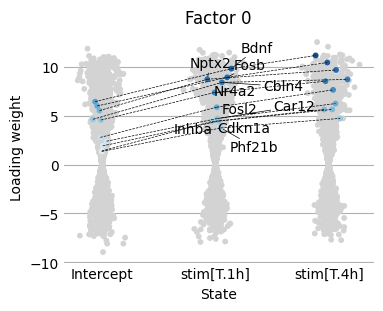

In [42]:
scp.pl.loadings_scatter(adata, 'm0', ['Intercept', 'stim[T.1h]', 'stim[T.4h]'], 0, sign=-1, var_names=loading_diff0.gene.tolist(), show_labels=1)

We find that this gene set is enriched for neuronal immediate early genes (IEGs) and activity-induced transcription factors.

| Gene       | Function / Annotation                                                                 |
|------------|----------------------------------------------------------------------------------------|
| **Fosb**, **Fosl2** | Core **immediate early genes (IEGs)**; rapidly induced by neuronal activity; components of the **AP-1 transcription factor complex**. |
| **Egr2**, **Egr4**   | **Early growth response** transcription factors; induced by neuronal depolarization and activity. |
| **Nr4a2**           | **Nuclear receptor** involved in **dopaminergic neuron function**, plasticity, and survival. |
| **Gadd45b**         | Activity-dependent gene involved in **DNA demethylation** and **neuroplasticity**. |
| **Tnfaip6**         | Induced by **inflammation and neuronal stimulation**; involved in **extracellular matrix remodeling**. |
| **Bdnf**            | **Brain-derived neurotrophic factor**; crucial for **synaptic plasticity, learning, and memory**. |
| **Pim1**            | Activity-induced **serine/threonine kinase**, regulates **cell survival** in neurons. |
| **Nptx2**           | **Neuronal pentraxin**, secreted protein involved in **synapse remodeling and homeostatic plasticity**. |


Likewise we can try to elucdiate gene expression shifts between reference (baseline) and 4h condition.

In [38]:
loading_diff0 = scp.tl.state_diff(adata, model_key='m0', states=['Intercept', 'stim[T.4h]'], factor=0, sign=-1)

<Axes: title={'center': 'Factor 0'}, xlabel='State', ylabel='Loading weight'>

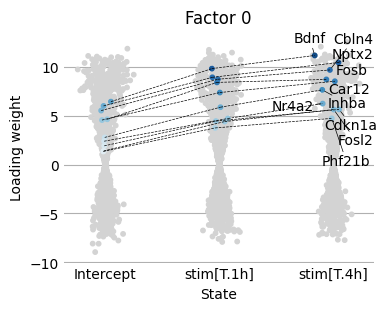

In [41]:
scp.pl.loadings_scatter(adata, 'm0', ['Intercept', 'stim[T.1h]', 'stim[T.4h]'], 0, sign=-1, var_names=loading_diff0.gene.tolist(), show_labels=2)